In [2]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
import tensorflow_datasets as tfds

data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteLMLL9B/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteLMLL9B/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


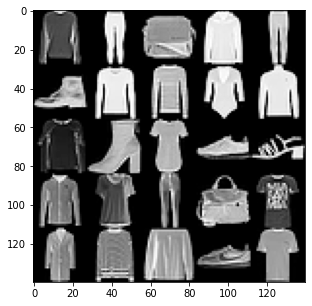

In [5]:
# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

# Task 1 (5 points + 1 point for the short comment)¶

Fill the gaps below to build a convolutional neural network and classify the images. Write a short comment on the validation metric images that you should obtain in the last cell.

Some hints for classes:

- tf.keras.layers.Conv2D - convolutional layer
- tf.keras.layers.MaxPool2D - maxpool layer
- tf.keras.layers.BatchNormalization - batchnorm layer
- tf.keras.layers.Dropout - dropout layer
- tf.keras.layers.Reshape - reshaping layer (to convert the image-like representation to a vector-like representation deep down in the network

Try to follow the general deep convolutional architecture:

- combine convolutions with maxpoolings to reduce the spacial size of the representation
- increase the number of filters as you go deeper
- when the spacial size of your representation is small enough (1-2 pixels), convert (reshape) it to a vector and then use fully connected layers

As you do this task, try to answer the following questions to yourself:

- should I place batchnorm before or after the activation function?
(to answer this one, think how inactive neurons would affect the batchnorm statistics)
- should I add dropout before or after batchnorm?
(think how batchnorm and dropout might interfere)
- do I need an activation for the output layer?
(check the loss function used)
- does it make sense to add a dropout to the output layer?
(common sense)
- is it a good idea to add a batchnorm to the output layer?
(in fact, I don't have a good answer to this one, but imo a batchnorm in the last layer might lead to weird effects)

In [6]:
def build_model(use_batchnorm=False, dropout_rate=0.):
  """
  Fill in the layers below.

  If use_batchnorm is True, add a batchnorm layer to **every** convolution and
  dense layer (except for the output one).
  If dropout_rate > 0, add a dropout layer with `rate=dropout_rate` to **every**
  convolution and dense layer (except for the output one).
  """

  layers = []
  
  # first block
  layers.append(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')) 
  if use_batchnorm: layers.append(tf.keras.layers.BatchNormalization())
  tf.keras.layers.MaxPooling2D(pool_size=(2,2))
  if dropout_rate > 0: layers.append(tf.keras.layers.Dropout(dropout_rate))
  
  # second block
  layers.append(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
  if use_batchnorm: layers.append(tf.keras.layers.BatchNormalization())
  tf.keras.layers.MaxPooling2D(pool_size=(2,2))
  if dropout_rate > 0: layers.append(tf.keras.layers.Dropout(dropout_rate))
  
  # flattening followed by dense layer and final output layer
  layers.append(tf.keras.layers.Flatten())
  layers.append(tf.keras.layers.Dense(128, activation='relu'))
  if use_batchnorm: layers.append(tf.keras.layers.BatchNormalization())
  if dropout_rate > 0: layers.append(tf.keras.layers.Dropout(dropout_rate))
  layers.append(tf.keras.layers.Dense(10, activation='softmax'))

  model = tf.keras.Sequential(layers)
  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  return model

In [7]:
configs = [
  dict(use_batchnorm=False, dropout_rate=0),
  dict(use_batchnorm=False, dropout_rate=0.01),
  dict(use_batchnorm=False, dropout_rate=0.05),
  dict(use_batchnorm=False, dropout_rate=0.5),
  dict(use_batchnorm=True, dropout_rate=0),
  dict(use_batchnorm=True, dropout_rate=0.01),
  dict(use_batchnorm=True, dropout_rate=0.05),
  dict(use_batchnorm=True, dropout_rate=0.5),
]

models = {str(config) : build_model(**config) for config in configs}

In [9]:
batch_size = 512

def preprocess(x):
  return (tf.cast(x['image'], 'float32') / 255., x['label'])

for config, model in models.items():
  print("Working on model:", config)
  model.fit(x=data_train.map(preprocess).shuffle(60000).batch(batch_size), epochs=10,
            validation_data=data_test.map(preprocess).batch(4096))

Working on model: {'use_batchnorm': False, 'dropout_rate': 0}
Epoch 1/10
118/118 [==============================] - 138s 1s/step - loss: 1.7162 - sparse_categorical_accuracy: 0.7488 - val_loss: 1.6512 - val_sparse_categorical_accuracy: 0.8127
Epoch 2/10
118/118 [==============================] - 137s 1s/step - loss: 1.6127 - sparse_categorical_accuracy: 0.8495 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.8538
Epoch 3/10
118/118 [==============================] - 137s 1s/step - loss: 1.5890 - sparse_categorical_accuracy: 0.8731 - val_loss: 1.5903 - val_sparse_categorical_accuracy: 0.8718
Epoch 4/10
118/118 [==============================] - 138s 1s/step - loss: 1.5747 - sparse_categorical_accuracy: 0.8874 - val_loss: 1.5796 - val_sparse_categorical_accuracy: 0.8838
Epoch 5/10
118/118 [==============================] - 137s 1s/step - loss: 1.5660 - sparse_categorical_accuracy: 0.8964 - val_loss: 1.5733 - val_sparse_categorical_accuracy: 0.8881
Epoch 6/10
118/118 [=============

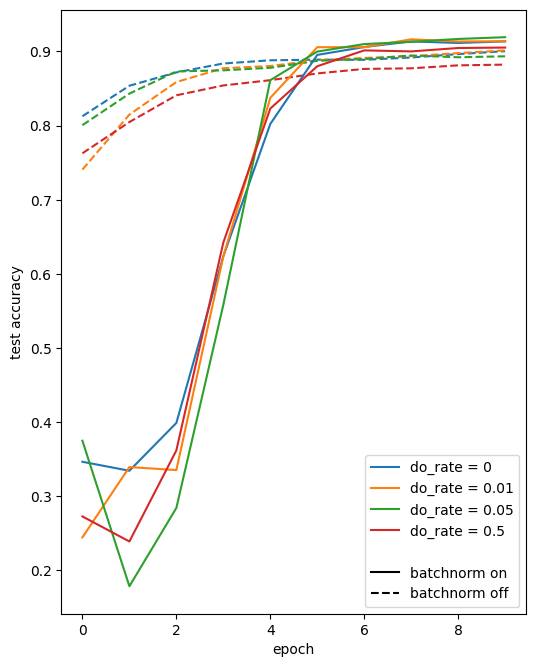

In [15]:
plt.figure(figsize=(6, 8), dpi=100)
color_cycle = iter(plt.rcParams['axes.prop_cycle'])

colors = {}

lines = []
labels = []
for config, model in models.items():
  config = eval(config)
  if config['dropout_rate'] not in colors:
    colors[config['dropout_rate']] = next(color_cycle)

  color = colors[config['dropout_rate']]['color']

  style = '-' if config['use_batchnorm'] else '--'
  line, = plt.plot(model.history.history['val_sparse_categorical_accuracy'], style,
                   c=color)
  
  if config['use_batchnorm']:
    lines.append(line)
    labels.append(f"do_rate = {config['dropout_rate']}")

plt.xlabel("epoch")
plt.ylabel("test accuracy");

from matplotlib.lines import Line2D

lines += [Line2D([0], [0], linestyle='-', color='w'),
          Line2D([0], [0], linestyle='-', color='k'),
          Line2D([0], [0], linestyle='--', color='k')]
labels += ['', 'batchnorm on', 'batchnorm off']
plt.legend(lines, labels);

As far as I understand, both BatchNorm and Dropout can be seen as those adding noise* to a NN to force the NN to learn to generalize well enough to deal with noise (it's oversimplification, of course).

So my intuition about the resulting picture is next. When we have both BatchNorm and Dropout in a CNN architechture, they first bring too much noise to the model comparing with BatchNorm off mode.  So the model needs some time (several epochs) to learn how to deal with this noise, but when it learns it starts to perform better. 

*see the [comment by Ian Goodfellow](https://www.quora.com/What-is-the-difference-between-dropout-and-batch-normalization/answer/Ian-Goodfellow) about adding noise